In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
from datetime import date,timedelta
%matplotlib inline
os.getcwd()

'/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-berezin-33/first_project'

In [2]:
customers_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-berezin-33/olist_customers_dataset.csv')
items_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-berezin-33/olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])
orders_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-berezin-33/olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])

### Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. 
### Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

In [167]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [168]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [169]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


###  Продажа
Для ее определения будем использовать таблицу  orders_df, т.к. в ней есть колонка order_approved_at в которой отражены все совершенные оплаты товара, исходя из полученной информации данная колонка имеет 99 281 строку, это значит что ровно такое количество пользователй совершили оплату, не зависимо от статуса заказа. 
Ниже я продемонстрирую какие статусы заказа входят в данную группу.

In [63]:
payment = orders_df.groupby(['order_approved_at', 'customer_id', 'order_status'], as_index=False).agg({'order_id' : 'count'})
payment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99281 entries, 0 to 99280
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_approved_at  99281 non-null  datetime64[ns]
 1   customer_id        99281 non-null  object        
 2   order_status       99281 non-null  object        
 3   order_id           99281 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 3.8+ MB


In [64]:
payment.order_status.value_counts()

delivered      96464
shipped         1107
unavailable      609
canceled         484
invoiced         314
processing       301
approved           2
Name: order_status, dtype: int64

### 1.Сколько у нас пользователей, которые совершили покупку только один раз?

Для этого возьмем всех пользователей которые совершили хоть одну оплату и проверим их, на количество покупок, затем из этого числа пользователей, отделим число тех кто совершил покупку только один раз и получим ответ на поставленный вопрос.

In [65]:
customer_orders = orders_df.merge(customers_df, on='customer_id', how='left')

#### Подсчет всех пользователей которые совершили покупки.

In [66]:
order_count = customer_orders.groupby(['order_approved_at', 'customer_unique_id'],  as_index=False) \
               .agg({'order_id' : 'count'}) \
               .groupby('order_id', as_index=False).agg({'customer_unique_id':'count'})
order_count

,order_id,customer_unique_id
0,1,99114
1,2,82
2,3,1


## Вывод:

Таким образом мы получили 99 114 человек, которые совершили 1 покупку. А так же дополнительно нашли тех пользователей, кто совершил иное количество покупок.

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

In [67]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


#### Рассмотрим общее число не доставленных заказов и сгруппируем клиентов по статусам заказ.
Отберем заказы с статусом  canceled и unavailable, т.к. данные заказы являются не доставленными по разным причинам, например пользователь сам отказался от заказа, товар кончился на складе или что то произошло во время доставки, что не позволило доставить заказ клиенту.

In [68]:
value = orders_df.query('order_status != "delivered"') \
                 .groupby(['order_estimated_delivery_date', 'order_status'], as_index=False) \
                 .agg({'order_id':'count'}) \
                 .pivot(index='order_estimated_delivery_date', columns='order_status', values='order_id') \
                 .resample('M', 'index').sum()

In [69]:
value[['canceled', 'unavailable']].mean().round()

order_status
canceled       23.0
unavailable    23.0
dtype: float64

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [70]:
items_orders = items_df.merge(orders_df, how='left', on='order_id')

In [71]:
items_orders.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05


In [72]:
items_orders['day'] = items_orders['order_approved_at'].dt.day_name()

In [73]:
items_orders.groupby(["product_id", "day"], as_index=False) \
    .agg({"customer_id": "count"}) \
    .sort_values(by="customer_id", ascending=False) \
    .drop_duplicates(subset='product_id')

,product_id,day,customer_id
41082,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
20152,53b36df67ebb7c41585e8d54d6772e08,Tuesday,105
15933,422879e10f46682990de24d770e7f83d,Tuesday,89
36574,99a4788cb24856965c36a24e339b6058,Tuesday,82
13060,368c6c730842d78016ad823897a372db,Thursday,80
...,...,...,...
23976,63dfa8b12200610ed7b5e41d3c888a25,Saturday,1
23980,63e51e65ec59b56039c6427eed73dcf0,Tuesday,1
23981,63eb97106bfe47fe857edcf78f3e3e08,Saturday,1
23991,63f52009dc3ddb733394e80183aed0f0,Saturday,1


#### Вывод:
Получили таблицу на 32 948 строк, с разбивкой по дням недели и количеством пользователей совершивших покупки в этот день, в качестве маркера использовали product_id, что и позволило сделать такую разбивку.

## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

In [74]:
cust_order = customers_df[['customer_id', 'customer_unique_id']] \
                            .merge(orders_df[['order_approved_at', 'customer_id']], on='customer_id') \
                            .dropna() \
                            .sort_values('order_approved_at')

In [75]:
cust_order

,customer_id,customer_unique_id,order_approved_at
21125,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15 12:16:38
17531,b3a9bf200375f53cc5c6991919c356fd,14359ea0c7a105749c0a56478825b015,2016-10-04 09:43:32
59705,70fc57eeae292675927697fe03ad3ff5,b8b8726af116a5cfb35b0315ecef9172,2016-10-04 10:18:57
19876,7812fcebfc5e8065d31e1bb5f0017dae,87776adb449c551e74c13fc34f036105,2016-10-04 10:19:23
21796,da0ba2a9935bca5b4610b0e3bca9d3b4,88bc832f104b6dd684a17dbb1b76e778,2016-10-04 10:25:46
...,...,...,...
495,6e353700bc7bcdf6ebc15d6de16d7002,7febafa06d9d8f232a900a2937f04338,2018-08-29 14:30:23
84603,e60df9449653a95af4549bbfcb18a6eb,5c58de6fb80e93396e2f35642666b693,2018-08-29 14:31:07
49885,496630b6740bcca28fce9ba50d8a26ef,b701bebbdf478f5500348f03aff62121,2018-08-29 15:05:22
67281,898b7fee99c4e42170ab69ba59be0a8b,24ac2b4327e25baf39f2119e4228976a,2018-08-29 15:10:26


#### Приводим колнку к виду ГГГГ-ММ.

In [76]:
cust_order['year_month'] = cust_order["order_approved_at"].dt.to_period("M")

#### Считаем количества недель в месяц.

In [77]:
cust_order['weeks'] = cust_order.year_month.dt.days_in_month / 7

#### Группируем данные для расчета среднего кол-ва выполненых заказов.

In [78]:
cust_order = cust_order \
    .groupby(['customer_unique_id','year_month','weeks'], as_index=False) \
    .agg({'customer_id':'count'}) \
    .groupby(['customer_unique_id','year_month','weeks'],as_index=False) \
    .agg({'customer_id':'sum'})

#### Выявляем среднее кол-во покупок.

In [79]:
cust_order['avg'] = cust_order.customer_id / cust_order.weeks

In [80]:
cust_order.head()

,customer_unique_id,year_month,weeks,customer_id,avg
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.428571,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,4.428571,1,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,4.428571,1,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,4.428571,1,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,4.285714,1,0.233333


#### Вывод: 
Получили таблицу с количеством недель в месяц и средним значением покупок в неделю.

## 5. Используя pandas, проведи когортный анализ пользователей. 
#### В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 

In [315]:
df_oc = orders_df.merge(customers_df, how='inner', on='customer_id')

In [539]:
# Создадим отдельный датафрейм под нашу задачу, т.к. все колонки для нас не нужны.
df_sss = df_oc[['customer_id', 'customer_unique_id', 'order_approved_at']]

#### Строить когорты будем исходя из определения покупки. 
Покупками мы считали все заказы которые имеют оплату, используем колонку order_approved_at, проверим ее на пустые значения и если такие будут, то от них мы избавимся и приступим к построению когорт.

In [540]:
df_sss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         99441 non-null  object        
 1   customer_unique_id  99441 non-null  object        
 2   order_approved_at   99281 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 3.0+ MB


In [541]:
df_sss.isna().sum()

customer_id             0
customer_unique_id      0
order_approved_at     160
dtype: int64

#### Мы избавились от пустых значений.

In [542]:
df_sss = df.dropna()

In [543]:
df_sss

,customer_id,customer_unique_id,order_approved_at
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 22:20:29
...,...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05
99437,1fca14ff2861355f6e5f14306ff977a7,da62f9e57a76d978d02ab5362c509660,2018-02-06 13:10:37
99438,1aa71eb042121263aafbe80c1b562c9c,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 15:04:16
99439,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:36:21


In [544]:
# Сортируем по дате
df_sss = df_sss.sort_values('order_approved_at', ascending=False)
df_sss.head()

,customer_id,customer_unique_id,order_approved_at
62360,4b7decb9b58e2569548b8b4c8e20e8d7,ff22e30958c13ffe219db7d711e8f564,2018-09-03 17:40:06
88097,898b7fee99c4e42170ab69ba59be0a8b,24ac2b4327e25baf39f2119e4228976a,2018-08-29 15:10:26
69678,496630b6740bcca28fce9ba50d8a26ef,b701bebbdf478f5500348f03aff62121,2018-08-29 15:05:22
30077,e60df9449653a95af4549bbfcb18a6eb,5c58de6fb80e93396e2f35642666b693,2018-08-29 14:31:07
31486,6e353700bc7bcdf6ebc15d6de16d7002,7febafa06d9d8f232a900a2937f04338,2018-08-29 14:30:23


In [545]:
# Переведем формат коллонки даты в месяц 
df_sss.order_approved_at = df_sss.order_approved_at.dt.to_period('M')

In [546]:
# Создадим коллонку с датой первого заказа
first_buy = df_sss.groupby('customer_unique_id', as_index=False).agg({'order_approved_at' : 'first'})

In [547]:
# Соеденим датасеты
df_sss = df_sss.merge(first_buy, how='inner', on='customer_unique_id')

In [548]:
df_sss = df_sss.rename(columns={'order_approved_at_x' : 'order_date', 'order_approved_at_y' : 'first_order_date'})
df_sss.head(2)

,customer_id,customer_unique_id,order_date,first_order_date
0,4b7decb9b58e2569548b8b4c8e20e8d7,ff22e30958c13ffe219db7d711e8f564,2018-09,2018-09
1,13bf775a749925a15ef7cc1985b564f1,ff22e30958c13ffe219db7d711e8f564,2018-08,2018-09


In [549]:
df_sss = df_sss.query("first_order_date >= '2017-01' & first_order_date <= '2017-12'")
df_sss

,customer_id,customer_unique_id,order_date,first_order_date
54772,dc3daad47c0792f3bd4366246a7955dc,5d11f19985edbb3c068e805434a80f87,2017-12,2017-12
54773,92566e623b70efba98063150b200cba4,b890928f02ba9a0dfbc6ec8009bee0fd,2017-12,2017-12
54774,2f368064b4e6646a7784a46b03b4bcbc,addd42012ed67639f9e0d26155b7c2e1,2017-12,2017-12
54775,98a1a1e41310f70974831b79bf01e4e6,e6797b7d4c35624ef13982ab27d3255b,2017-12,2017-12
54776,ce3fd019ee6c37bef63731c9aa9ae70e,746cb64489db5b37e7d7502a2b029bb6,2017-12,2017-12
...,...,...,...,...
98964,7dfd10dcc726950fc6171cea83872351,48368b31672665cca1b8a03047a1702a,2017-01,2017-01
98965,4b60b3ade055c6ad88a00758c8e8a162,b88b78a413e70182e18b032361b24f91,2017-01,2017-01
98966,758b633d88b82063db189810084f4ea9,4b3207464f5f7a48a7f63fa0b1251d86,2017-01,2017-01
98967,c24fc5f9a446b4d8262041b9c64de772,f7b981e8a280e455ac3cbe0d5d171bd1,2017-01,2017-01


In [550]:
# Подсчёт количества покупателей в разбивке по дате первой покупки и дате всех остальных покупок
df_sss = df_sss.groupby(['first_order_date', 'order_date'], as_index=False).agg({'customer_unique_id':'nunique'})
df_sss.head()

,first_order_date,order_date,customer_unique_id
0,2017-01,2016-12,1
1,2017-01,2017-01,693
2,2017-02,2017-01,4
3,2017-02,2017-02,1690
4,2017-03,2017-01,2


# Добавим функцию которая считает когорту


In [551]:
def cohort_period(cohorts):
    cohorts['cohort_period'] = np.arange(len(cohorts))
    return cohorts

df_sss = df_sss.groupby('first_order_date').apply(cohort_period)
df_sss.head()

,first_order_date,order_date,customer_unique_id,cohort_period
0,2017-01,2016-12,1,0
1,2017-01,2017-01,693,1
2,2017-02,2017-01,4,0
3,2017-02,2017-02,1690,1
4,2017-03,2017-01,2,0


In [552]:
# Создание наглядной сводной таблицы 
df_sss = df_sss.pivot(columns='cohort_period', index = 'first_order_date',values='customer_unique_id')
df_sss

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11
first_order_date,,,,,,,,,,,,
2017-01,1.0,693.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02,4.0,1690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03,2.0,4.0,2557.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04,1.0,1.0,4.0,11.0,2261.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05,1.0,2.0,7.0,14.0,3482.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06,1.0,7.0,7.0,5.0,16.0,3069.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,4.0,2.0,8.0,4.0,14.0,13.0,3772.0,NaN,NaN,NaN,NaN
2017-08,1.0,3.0,4.0,5.0,12.0,9.0,18.0,4121.0,NaN,NaN,NaN,NaN
2017-09,3.0,3.0,6.0,8.0,12.0,13.0,26.0,4091.0,NaN,NaN,NaN,NaN


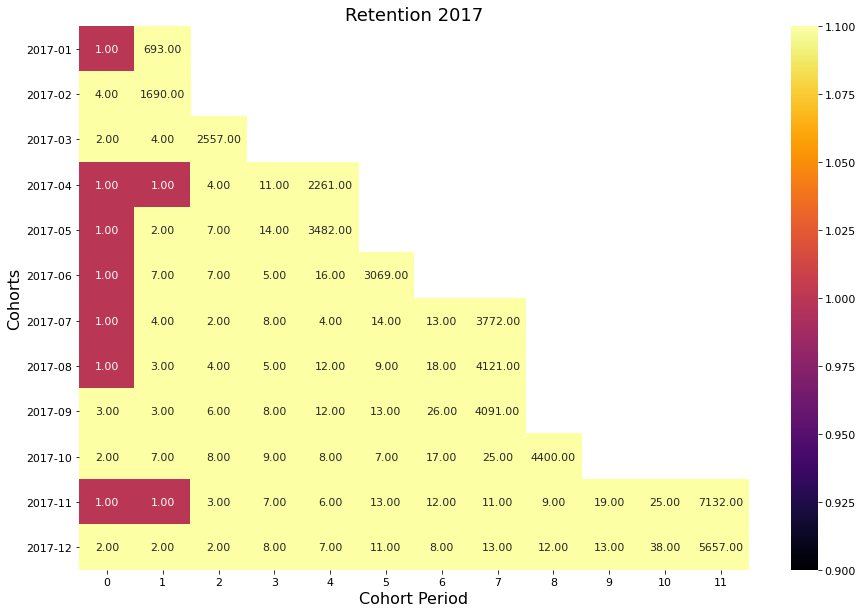

In [554]:
# Визуализация данных
plt.figure(figsize=(15,10))
ax = sns.heatmap(df_sss, vmax=1, annot=True, fmt='.2f', cmap='inferno')
plt.xlabel('Cohort Period',size= 16)
plt.ylabel('Cohorts', size= 16)
plt.title('Retention 2017', size= 18)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

### 6. Построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 
В кластеризации можешь выбрать следующие метрики: 
R - время от последней покупки пользователя до текущей даты 
F - суммарное количество покупок у пользователя за всё время, 
M - сумма покупок за всё время.
Подробно опиши, как ты создавал кластеры. 
Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

### Подготовка данных для удобной работы, соеденим все три датафрейма.

In [3]:
rfm_df = orders_df[['order_id', 'customer_id', 'order_approved_at']] \
                .merge(customers_df[['customer_id', 'customer_unique_id']], on='customer_id', how='left') \
                .merge(items_df[['order_id', 'order_item_id', 'product_id', 'price']], on='order_id', how='left')

In [4]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   order_id            113425 non-null  object        
 1   customer_id         113425 non-null  object        
 2   order_approved_at   113264 non-null  datetime64[ns]
 3   customer_unique_id  113425 non-null  object        
 4   order_item_id       112650 non-null  float64       
 5   product_id          112650 non-null  object        
 6   price               112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 6.9+ MB


In [5]:
rfm_df = rfm_df.drop(columns=['customer_id', 'product_id', 'order_item_id'])

##### Т.к. мы ориентируемся на определение покупки, установленное в самом начале, то нужно удалить пустые значения из колонки order_approved_at.

In [6]:
rfm_df.isna().sum()

order_id                0
order_approved_at     161
customer_unique_id      0
price                 775
dtype: int64

In [7]:
rfm_df = rfm_df.dropna(subset=['order_approved_at'])

##### Отчистили данные, теперь мы имеем все оплачанные заказы и можем приступать к работе.

In [8]:
rfm_df['order_approved_at'] = pd.to_datetime(rfm_df['order_approved_at'])
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113264 entries, 0 to 113424
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   order_id            113264 non-null  object        
 1   order_approved_at   113264 non-null  datetime64[ns]
 2   customer_unique_id  113264 non-null  object        
 3   price               112635 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 4.3+ MB


In [9]:
# Определение даты последней покупки.
last_buy = rfm_df.order_approved_at.max()+ timedelta(days=1)

In [10]:
last_buy

Timestamp('2018-09-04 17:40:06')

In [11]:
rfm = rfm_df.groupby('customer_unique_id', as_index=False) \
            .agg({'order_approved_at': lambda x: (last_buy - x.max()).days, 
                  'order_id': lambda x: len(x), 
                  'price': lambda x: x.sum()}) \
            .rename(columns={'order_approved_at' : 'recency', 'order_id' : 'frequency', 'price' : 'monetary'})

In [16]:
# Определение квантилей каждой метрики для разделения их на 4 группы
quintiles = rfm[['recency', 'frequency', 'monetary']].quantile([.2, .4, .6, .8])
quintiles

,recency,frequency,monetary
0.2,98.0,1.0,39.0
0.4,183.0,1.0,69.0
0.6,274.0,1.0,109.9
0.8,389.0,1.0,179.9


In [18]:
# Присвоение рангов от 1 до 5. 
def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5 

In [19]:
# Выставляем оценки 
rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: fm_score(x, 'frequency'))
rfm['M'] = rfm['monetary'].apply(lambda x: fm_score(x, 'monetary'))

In [20]:
# Объединяю оценки R, F и M
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,5,215


In [26]:
rfm = rfm.rename(columns={'RFM Score' : 'RFM'})

In [29]:
# Смотрим количество сигментов 
rfm.RFM.nunique()

50

#### Т.к. у нас большое количество RFM сигментов, то сделаем разбивку по  следующим критериям:

- VIP - покупали относительно часто, на большую сумму и последняя покупка была недавно (R-score 3-4; F-score 3-4; M-score 3-4)
- can't loose - покупали часто на большую сумму, но давно (R-score 1-2; F-score 3-4; M-score 3-4)
- need attention - покупали редко на большую сумму, но давно (R-score 1-2; F-score 1-2; M-score 3-4)
- loyal customers - купили дважды, в последний раз - недавно и на большую сумму (R-score 3-4; F-score 2; M-score 3-4)
- potential loyalists - купили однажды недавно и на большую сумму (R-score 3-4; F-score 1; M-score 3-4)
- promising - покупали 2-3 раза, последний раз недавно, но на маленькие суммы (R-score 3-4; F-score 2-3; M-score 1-2)
- recent - купили недавно и на маленькую сумму (R-score 3-4; F-score 1; M-score 1-2)
- about to sleep - покупали часто, но давно и на маленькие суммы (R-score 1-2; F-score 2-4; M-score 1-2)
- lost - купили однажды давно и на маленькую сумму (R-score 1-2; F-score 1; M-score 1-2)

In [60]:
segments = {
    r'[3-5][3-5][3-5]': 'VIP',
    r'[1-2][3-5][3-5]': 'can\'t loose',
    r'[1-2][1-2][3-4]': 'need attention',
    r'[3-4]2[3-4]': 'loyal customers',
    r'[3-4]1[3-4]': 'potential loyalists',
    r'[3-5][1-5][1-2]': 'promising',
    r'[3-5]1[1-5]': 'recent',
    r'[1-2][2-5][1-2]': 'about to sleep',
    r'[1-2]1[1-5]': 'lost',
}

rfm['segment'] = rfm['RFM'].replace(segments, regex=True)
rfm.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4,1,4,414,potential loyalists
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411,promising
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112,lost
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211,lost
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,5,215,lost


In [68]:
seg_count = rfm.groupby('segment', as_index=False).agg({'customer_unique_id' : 'count'}).sort_values('customer_unique_id')

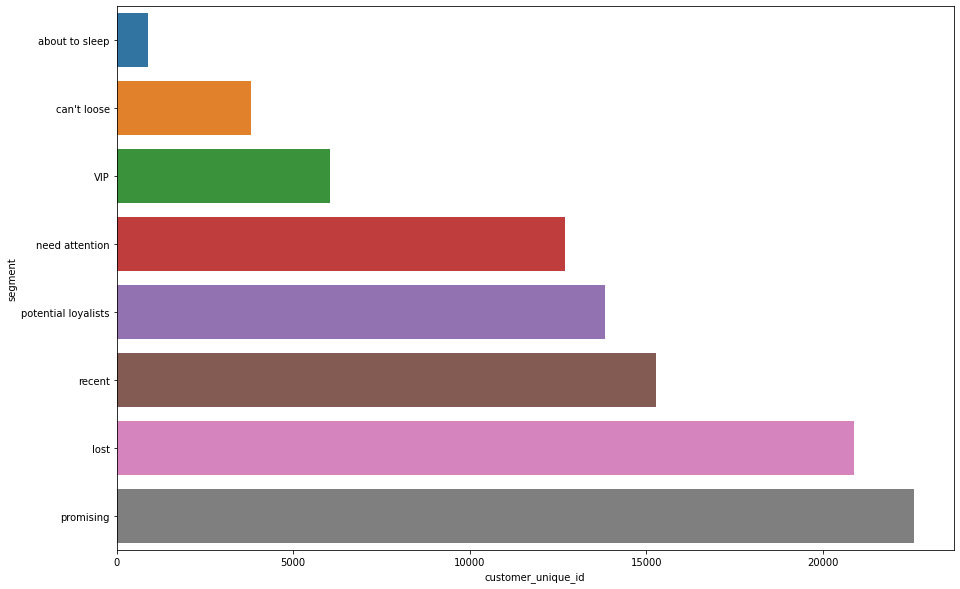

In [71]:
plt.figure(figsize=(15,10))
sns.barplot(data=seg_count, x="customer_unique_id", y="segment")